In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

In [2]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [3]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [4]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [5]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [6]:
testing_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [8]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.5), 
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 250, 250, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                        

In [11]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 25, callbacks=callbacks_list)

Epoch 1/25


8/8 [==============================] - ETA: 0s - loss: 2.0073 - accuracy: 0.5537 
Epoch 1: val_accuracy improved from -inf to 0.46939, saving model to model_weights.h5


C:\Users\YUVARAJ\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 119s 13s/step - loss: 2.0073 - accuracy: 0.5537 - val_loss: 0.7483 - val_accuracy: 0.4694
Epoch 2/25
8/8 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5891
Epoch 2: val_accuracy did not improve from 0.46939
8/8 [==============================] - 50s 6s/step - loss: 0.6883 - accuracy: 0.5891 - val_loss: 1.1622 - val_accuracy: 0.4694
Epoch 3/25
8/8 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.6005
Epoch 3: val_accuracy did not improve from 0.46939
8/8 [==============================] - 56s 7s/step - loss: 0.6657 - accuracy: 0.6005 - val_loss: 0.7181 - val_accuracy: 0.4694
Epoch 4/25
8/8 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.6283 
Epoch 4: val_accuracy improved from 0.46939 to 0.62245, saving model to model_weights.h5
8/8 [==============================] - 92s 12s/step - loss: 0.6404 - accuracy: 0.6283 - val_loss: 0.6224 - val_accuracy: 0.6224
Epoch 5/25
8/8 [=====

In [13]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

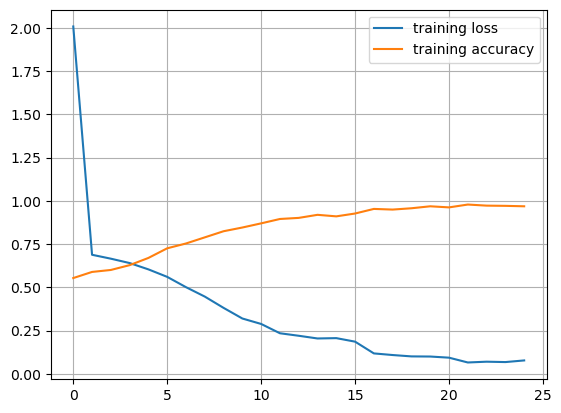

In [14]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

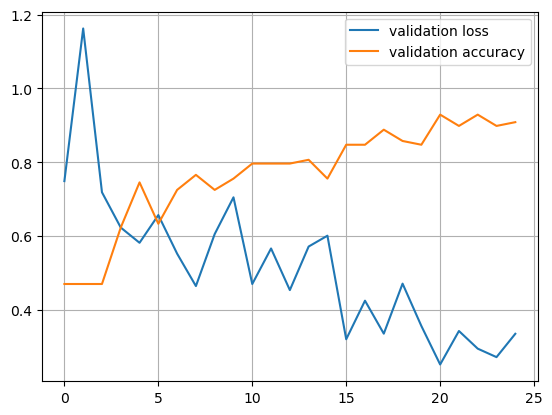

In [15]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [16]:
## Load the best model from checkpoint
best_model = load_model("model_weights.h5")

In [18]:
## Evaluate the best model on the testing dataset
test_loss, test_accuracy = best_model.evaluate(testing_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 3s 3s/step - loss: 0.2428 - accuracy: 0.9100
Test Loss: 0.24275541305541992
Test Accuracy: 0.9100000262260437
